In this notebook, I explored the possibility of choosing only resonances below 0 which removes a lot of the noise. It also diminishes the signal a bit though so it didn't really come out better. I think it is promising though so maybe a bit more work should be done on it.

In [576]:
%load_ext autoreload
%autoreload 1
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
%aimport analysis
%aimport learning
%aimport NV_generator

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
B_field = 0.0403555 # Teslas
gam_c = 67.262 * 10 ** 6 # Gyromagnetic ratio for a single c13 nucleus in rad s-1 T-1
ms = 1
omega_larmor = -1 * ms * gam_c * B_field

In [4]:
diamond = learning.load_obj("diamonds/diamond_21")

In [364]:
def data_func(N, tau, noise_level = .02): #put the noise at .02
    data = analysis.calc_M(diamond["A"], diamond["B"], N, omega_larmor, tau)
    noise = np.random.randn(len(data)) * noise_level
    return data + noise

### Current method

In [25]:
from analysis import *
verbose, plots = False, False
# from analyze diamond
N = 64
tau = choose_tau_params(N)
data = data_func(N, tau)
dip_inds, windows = find_resonances(data, fit_dips_below = None)
print sum(dip_inds >= 3220)

382


In [26]:
spin_dict = {}
for dii in range(len(dip_inds)):
    dip_ind = dip_inds[dii]
    if dip_ind >= 3220: # 15 microseconds and on
        spin_dict = analyze_dip(dip_ind, tau, data_func, omega_larmor, spin_dict, N_vals = np.arange(0,256,2),
            error_tol = .1/64, verbose = verbose, plots = plots)

In [27]:
# from choose_spin_guesses
error_fun = squared_error
select_As, select_Bs = [], []
for k in spin_dict.keys():
    err = []
    for A, B, _ in spin_dict[k]:
        err.append(error_fun(calc_M_single(A, B, N, omega_larmor, tau), data))
    min_err_ind = np.argmin(err)
    best_A, best_B, best_cosphi = spin_dict[k][min_err_ind]
    select_As.append(best_A)
    select_Bs.append(best_B)
select_As = np.array(select_As)
select_Bs = np.array(select_Bs)

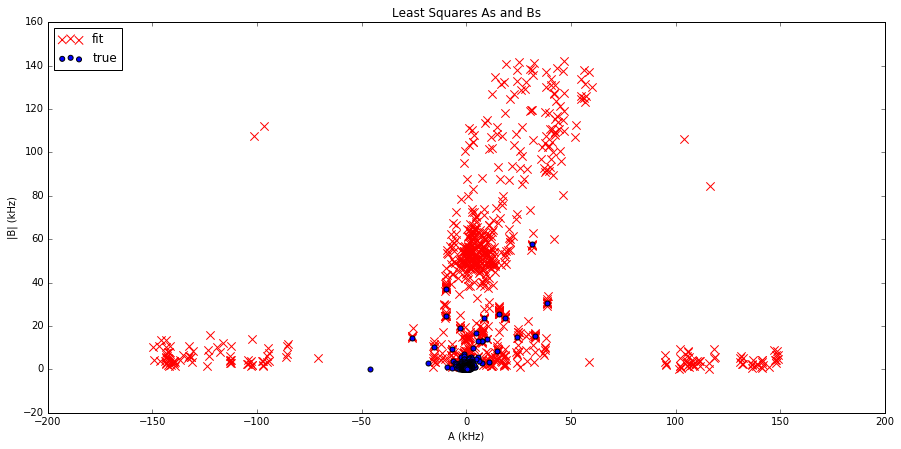

In [28]:
%matplotlib inline
diamond_ind = 21
plt.figure(figsize=(15,7))
plt.title("Least Squares As and Bs")
plt.xlabel("A (kHz)")
plt.ylabel("|B| (kHz)")
plt.scatter(select_As/analysis.mag, np.abs(select_Bs)/analysis.mag, c='r', marker = 'x', s = 70, label = 'fit')
plt.scatter(diamond["A"]/analysis.mag, np.abs(diamond["B"])/analysis.mag, c='b', marker = 'o', s = 25, label = 'true')
plt.legend(loc=2)
#plt.savefig(figures_path + "Fitted_A_B/least_squares_guesses")
plt.show()

### Only below 0

In [32]:
dip_inds, windows = find_resonances(data, fit_dips_below = 0)
print sum(dip_inds >= 3220)

64


In [46]:
# from choose_spin_guesses
error_fun = squared_error
select_As, select_Bs = [], []
for k in spin_dict.keys():
    if k[0] in dip_inds and k[2] >= 1:
        err = []
        for A, B, _ in spin_dict[k]:
            err.append(error_fun(calc_M_single(A, B, N, omega_larmor, tau), data))
        min_err_ind = np.argmin(err)
        best_A, best_B, best_cosphi = spin_dict[k][min_err_ind]
        select_As.append(best_A)
        select_Bs.append(best_B)
select_As = np.array(select_As)
select_Bs = np.array(select_Bs)

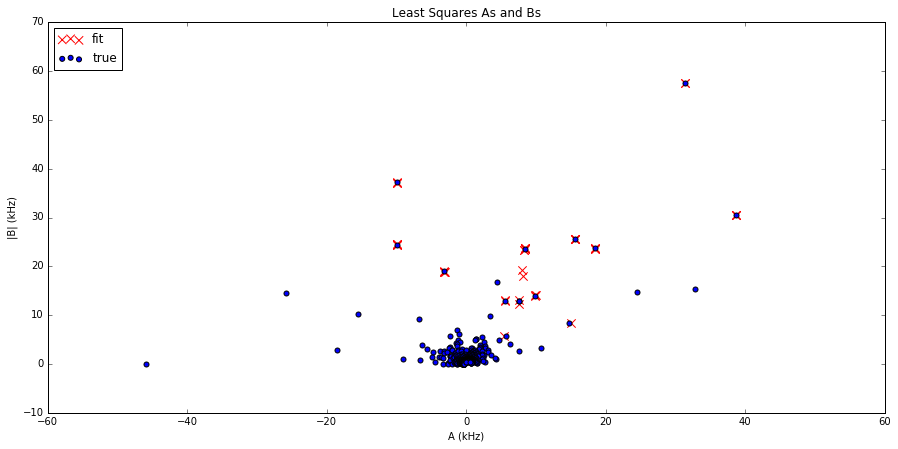

In [47]:
%matplotlib inline
diamond_ind = 21
plt.figure(figsize=(15,7))
plt.title("Least Squares As and Bs")
plt.xlabel("A (kHz)")
plt.ylabel("|B| (kHz)")
plt.scatter(select_As/analysis.mag, np.abs(select_Bs)/analysis.mag, c='r', marker = 'x', s = 70, label = 'fit')
plt.scatter(diamond["A"]/analysis.mag, np.abs(diamond["B"])/analysis.mag, c='b', marker = 'o', s = 25, label = 'true')
plt.legend(loc=2)
#plt.savefig(figures_path + "Fitted_A_B/least_squares_guesses")
plt.show()

### Many N

In [454]:
diamond = learning.load_obj("diamonds/diamond_8")
def data_func(N, tau, noise_level = .02): #put the noise at .02
    data = analysis.calc_M(diamond["A"], diamond["B"], N, omega_larmor, tau)
    noise = np.random.randn(len(data)) * noise_level
    return data + noise

In [455]:
#N = 192
#tau = choose_tau_params(64, 5100)
#data = data_func(N, tau)
#dip_inds, _= find_resonances(data, fit_dips_below = 0, max_width = None)

In [643]:
N_list = [128, 160, 192, 224, 256]
tau = choose_tau_params(64, 5100)
dip_inds_dict = {}
datasets = {}
for N in N_list:
    data_N = data_func(N, tau)
    datasets[N] = data_N
    dip_inds_N, _ = find_resonances(data_N, fit_dips_below = -.02, max_width = None)
    for dip_ind in dip_inds_N:
        if dip_ind in dip_inds_dict:
            dip_inds_dict[dip_ind] += [N]
        else:
            dip_inds_dict[dip_ind] = [N]

In [644]:
len(dip_inds_dict)

873

In [594]:
spin_dict = {}
for dip_ind in dip_inds_dict.keys():
    spin_dict = analyze_dip(dip_ind, tau, data_func, omega_larmor, spin_dict, N_vals = np.arange(0,256,2),
                            error_tol = .1/64, verbose = verbose, plots = plots)

In [622]:
# from choose_spin_guesses
error_fun = squared_error
select_As, select_Bs, dataerrs = [], [], []
for k in spin_dict.keys():
    dip_ind, _, x = k
    if x >= 1:
        err = []
        N = max(dip_inds_dict[dip_ind])
        for A, B, _ in spin_dict[k]:
            err.append(error_fun(calc_M_single(A, B, N, omega_larmor, tau), datasets[N]))
        min_err_ind = np.argmin(err)
        best_A, best_B, best_cosphi = spin_dict[k][min_err_ind]
        best_err = err[min_err_ind]
        select_As.append(best_A)
        select_Bs.append(best_B)
        dataerrs.append(best_err)
select_As = np.array(select_As)
select_Bs = np.array(select_Bs)
dataerrs = np.array(dataerrs)
print len(select_As)

202


In [623]:
cluster_As, cluster_Bs, cluster_dataerrs = cluster_spin_guesses(select_As, select_Bs, dataerrs, eps = .075, min_samples = 2)

In [640]:
As, Bs, num_remove = cluster_As, cluster_Bs, 1
#while num_remove <= 2:
#    As, Bs, num_remove = remove_spins(As, Bs, 256, omega_larmor, tau, data, num_remove = num_remove, error_fun = squared_error, verbose=verbose)

In [641]:
num_correct = 0
spins = set(zip(diamond["A"], np.abs(diamond["B"])))
for A, B in zip(As, np.abs(Bs)):
    for spin in spins:
        if learning.is_fit(A, B, spin, A_acc = .5, B_acc = 2):
            num_correct = num_correct + 1
            spins.remove(spin)
            break
num_incorrect = len(As) - num_correct
print num_correct, num_incorrect

12 4


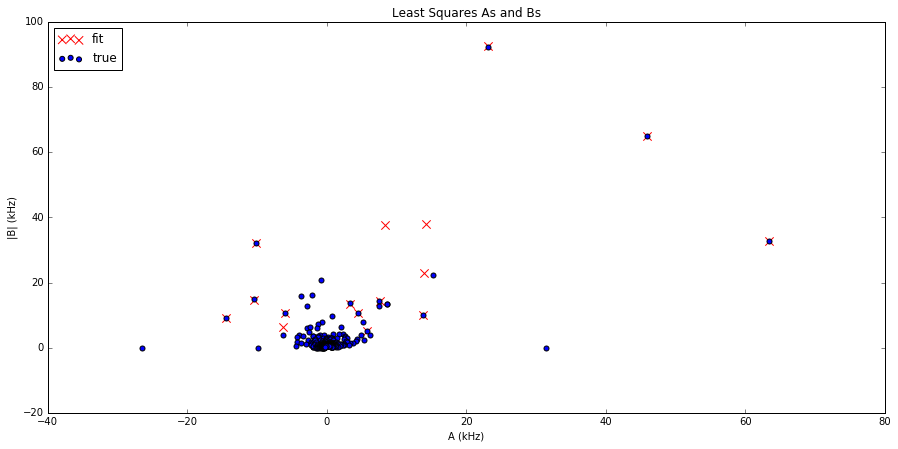

In [642]:
%matplotlib inline
diamond_ind = 21
plt.figure(figsize=(15,7))
plt.title("Least Squares As and Bs")
plt.xlabel("A (kHz)")
plt.ylabel("|B| (kHz)")
#plt.scatter(select_As/analysis.mag, np.abs(select_Bs)/analysis.mag, c='r', marker = 'x', s = 70, label = 'fit')
#plt.scatter(cluster_As/analysis.mag, np.abs(cluster_Bs)/analysis.mag, c='r', marker = 'x', s = 70, label = 'fit')
plt.scatter(As/analysis.mag, np.abs(Bs)/analysis.mag, c='r', marker = 'x', s = 70, label = 'fit')
plt.scatter(diamond["A"]/analysis.mag, np.abs(diamond["B"])/analysis.mag, c='b', marker = 'o', s = 25, label = 'true')
plt.legend(loc=2)
#plt.savefig(figures_path + "Fitted_A_B/least_squares_guesses")
plt.show()

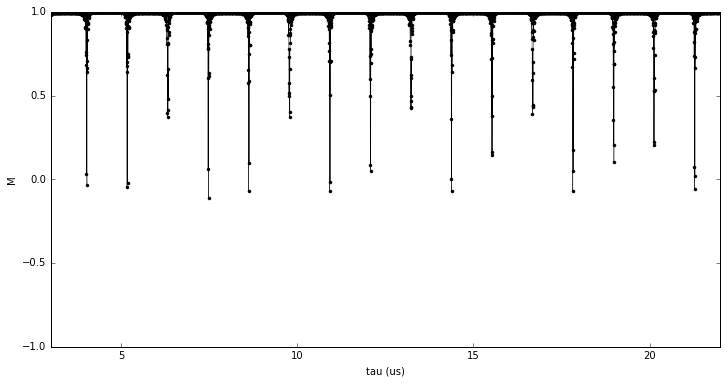

In [560]:
%matplotlib inline
fig,ax = analysis.initialize_data_plot(figsize = (12,6), xlims = [3,22], ylims = [-1,1])
ax.set_xlabel('tau (us)')
ax.set_ylabel('M')
tau = choose_tau_params(64, 5100)
ax.plot(tau * 1e6, calc_M_single(-5 * mag, 20 * mag, 256, omega_larmor, tau), '.-k', lw=0.4, label = 'data')
plt.show()

### Current method

In [577]:
As, Bs, all_guess_As, all_guess_Bs, select_As, select_Bs, guess_As, guess_Bs, cluster_As, cluster_Bs = analysis.analyze_diamond(data_func, 64, omega_larmor, verbose=False, plots=False)

388


In [590]:
num_correct = 0
spins = set(zip(diamond["A"], np.abs(diamond["B"])))
for A, B in zip(As, np.abs(Bs)):
    for spin in spins:
        if learning.is_fit(A, B, spin, A_acc = .5, B_acc = 2):
            num_correct = num_correct + 1
            spins.remove(spin)
            break
num_incorrect = len(cluster_As) - num_correct
print num_correct, num_incorrect

16 2


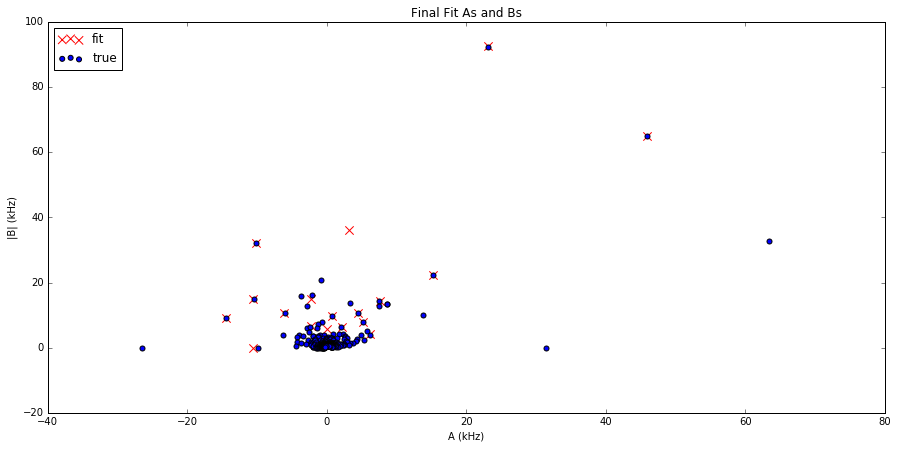

In [591]:
%matplotlib inline
plt.figure(figsize=(15,7))
plt.title("Final Fit As and Bs")
plt.xlabel("A (kHz)")
plt.ylabel("|B| (kHz)")
plt.scatter(As/analysis.mag, np.abs(Bs)/analysis.mag, c='r', marker = 'x', s = 70, label = 'fit')
plt.scatter(diamond["A"]/analysis.mag, np.abs(diamond["B"])/analysis.mag, c='b', marker = 'o', s = 25, label = 'true')
plt.legend(loc=2)
#plt.savefig(figures_path + "Fitted_A_B/final_guesses")
plt.show()